In [1]:
from google.colab import files
files.upload()  # Select the kaggle.json file
# Upload a file named: kaggle.json
# Copy paste the following into it: {"username":"muhammadzaeemrizwan","key":"74b9d065fbe470950f21c48f97e58fe9"}

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadzaeemrizwan","key":"74b9d065fbe470950f21c48f97e58fe9"}'}

In [2]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d muhammadzaeemrizwan/dataset
!kaggle datasets download -d muhammadzaeemrizwan/dataloaders

Dataset URL: https://www.kaggle.com/datasets/muhammadzaeemrizwan/dataset
License(s): unknown
100% 710M/712M [00:32<00:00, 23.8MB/s]
100% 712M/712M [00:32<00:00, 22.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/muhammadzaeemrizwan/dataloaders
License(s): unknown
100% 191k/191k [00:00<00:00, 381kB/s]
100% 191k/191k [00:00<00:00, 381kB/s]


In [4]:
!unzip dataset.zip -d /content/dataset
!unzip dataloaders.zip -d /content/dataloaders

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000034.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000035.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000036.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000037.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000038.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000039.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000040.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000041.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000042.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000043.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000044.jpg  
  inflating: /content/dataset/domain/Data/real/suitcase/real_295_000045.jpg  
  inflating: 

In [5]:
dataset_root = "/content/dataset/domain"
pathPKL = "/content/dataloaders"

# **Library Imports**

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.models import vgg16
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import resnet
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import copy
from torch.utils.data import Subset
import random
import os
import pickle
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import kagglehub

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
import os
from PIL import Image

In [7]:
class ImageDataset:
    def __init__(self, root_dir=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx].replace("\\", "/"))
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            print(f"No transform applied for image: {img_path}")
        return image, label


# Function to load dataset
def load_dataset(file_path, dataset_root, transform):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    dataset = ImageDataset(root_dir=dataset_root, transform=transform)
    dataset.images = data["images"]
    dataset.labels = data["labels"]
    dataset.class_to_idx = data["class_to_idx"]
    return dataset




# Function to visualize images
def visualize_same_label_across_domains(dataloaders, label_to_check, num_images_per_domain=5):
    """
    Visualize images of the same label across different domains.
    """
    fig, axes = plt.subplots(len(dataloaders), num_images_per_domain, figsize=(15, 10))
    fig.suptitle(f"Images with Label {label_to_check} Across Domains", fontsize=16)

    for i, (domain, dataloader) in enumerate(dataloaders.items()):
        domain_images_shown = 0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Find indices of the specified label
            indices = (labels == label_to_check).nonzero(as_tuple=True)[0]
            for idx in indices[:num_images_per_domain - domain_images_shown]:
                ax = axes[i, domain_images_shown] if len(dataloaders) > 1 else axes[domain_images_shown]
                image = images[idx].cpu().permute(1, 2, 0).numpy()  # Convert to HxWxC
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(f"{domain}")
                domain_images_shown += 1
                if domain_images_shown >= num_images_per_domain:
                    break
            if domain_images_shown >= num_images_per_domain:
                break

    plt.tight_layout()
    plt.show()
# Define correct paths
dataset_root = "/content/dataset/domain"


from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random

# Define the 10 classes to keep
selected_classes = list(range(10))  # Replace with specific class indices if needed

def filter_dataset(dataset, selected_classes):
    """
    Filters the dataset to include only the selected classes.
    """
    filtered_indices = [i for i, label in enumerate(dataset.labels) if label in selected_classes]
    filtered_images = [dataset.images[i] for i in filtered_indices]
    filtered_labels = [dataset.labels[i] for i in filtered_indices]

    # Update the dataset with filtered images and labels
    dataset.images = filtered_images
    dataset.labels = filtered_labels
    dataset.class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    return dataset

def create_train_test_dataloader(dataset_file, dataset_root, batch_size=32, test_size=0.2, shuffle=True, sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = load_dataset(dataset_file, dataset_root, transform)

    # Filter the dataset to include only the selected classes
    dataset = filter_dataset(dataset, selected_classes)

    # Sample a subset of the dataset if sample_size is specified
    if sample_size:
        indices = random.sample(range(len(dataset)), sample_size)
        dataset = Subset(dataset, indices)

    # Split indices for train and test
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Load centralized train and test DataLoaders
central_train_loader, central_test_loader = create_train_test_dataloader(
    "/content/dataloaders/central_dataset.pkl", dataset_root
)

# Load individual domain train and test DataLoaders for FedSGD
real_train_loader, real_test_loader = create_train_test_dataloader(
    "/content/dataloaders/real_dataset.pkl", dataset_root
)
sketch_train_loader, sketch_test_loader = create_train_test_dataloader(
    "/content/dataloaders/sketch_dataset.pkl", dataset_root
)
clipart_train_loader, clipart_test_loader = create_train_test_dataloader(
    "/content/dataloaders/clipart_dataset.pkl", dataset_root
)
quickdraw_train_loader, quickdraw_test_loader = create_train_test_dataloader(
    "/content/dataloaders/quickdraw_dataset.pkl", dataset_root
)
painting_train_loader, painting_test_loader = create_train_test_dataloader(
    "/content/dataloaders/painting_dataset.pkl", dataset_root
)
infograph_train_loader, infograph_test_loader = create_train_test_dataloader(
    "/content/dataloaders/infograph_dataset.pkl", dataset_root
)

# Combine train DataLoaders
train_dataloaders = {
    "real_dataset": real_train_loader,
    "sketch_dataset": sketch_train_loader,
    "clipart_dataset": clipart_train_loader,
    "quickdraw_dataset": quickdraw_train_loader,
    "painting_dataset": painting_train_loader,
    "infograph_dataset": infograph_train_loader
}

# Combine test DataLoaders
test_dataloaders = {
    "real_dataset": real_test_loader,
    "sketch_dataset": sketch_test_loader,
    "clipart_dataset": clipart_test_loader,
    "quickdraw_dataset": quickdraw_test_loader,
    "painting_dataset": painting_test_loader,
    "infograph_dataset": infograph_test_loader
}

print("Train and Test DataLoaders created successfully with 10 classes.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

Train and Test DataLoaders created successfully with 10 classes.
device: cuda


Visualizing Train Loader


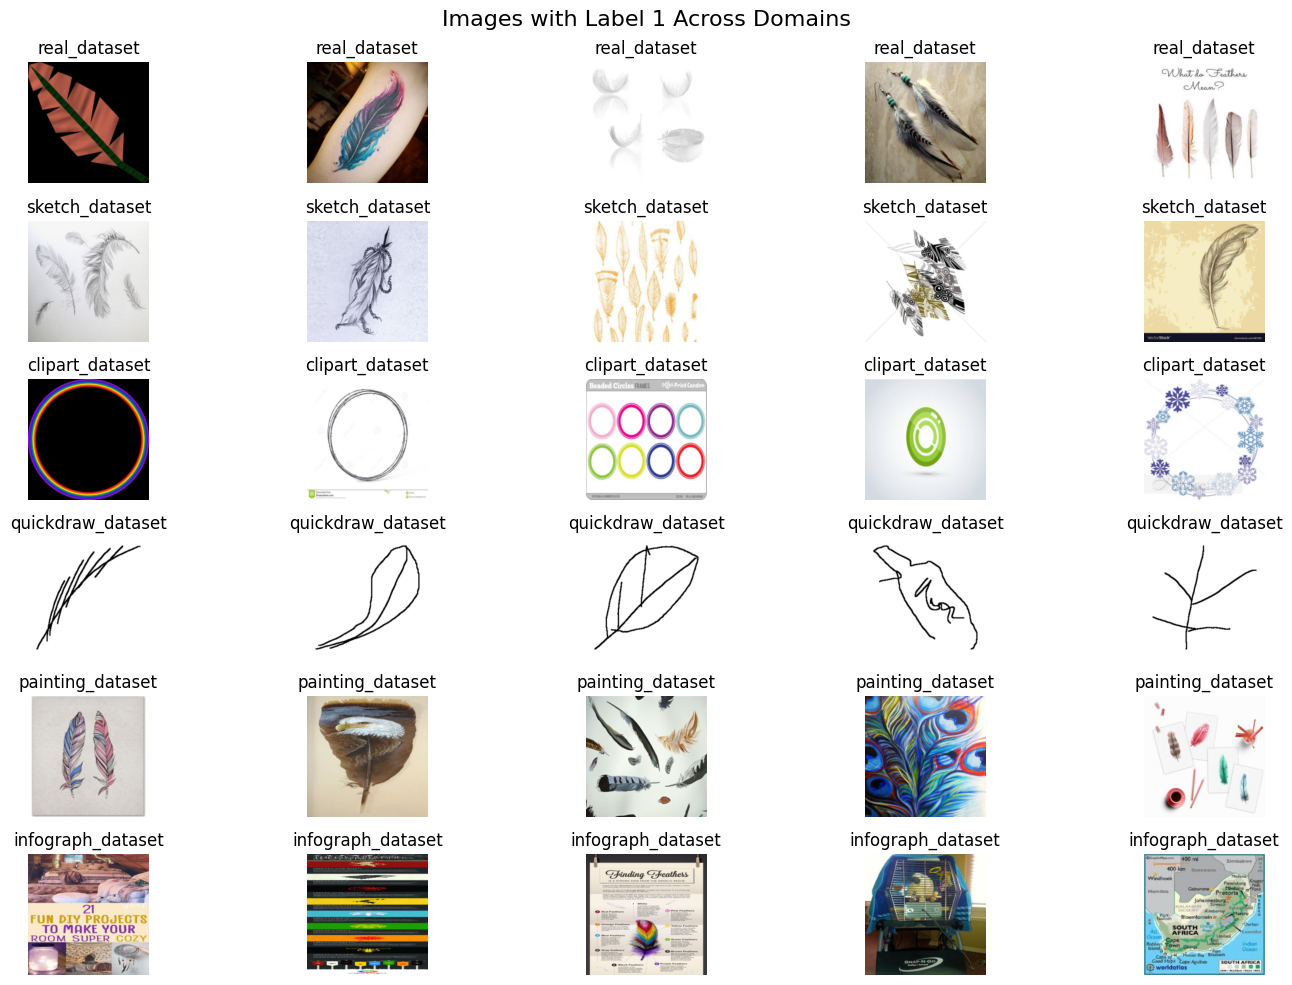

...
...
...
Visualizing Test Loader


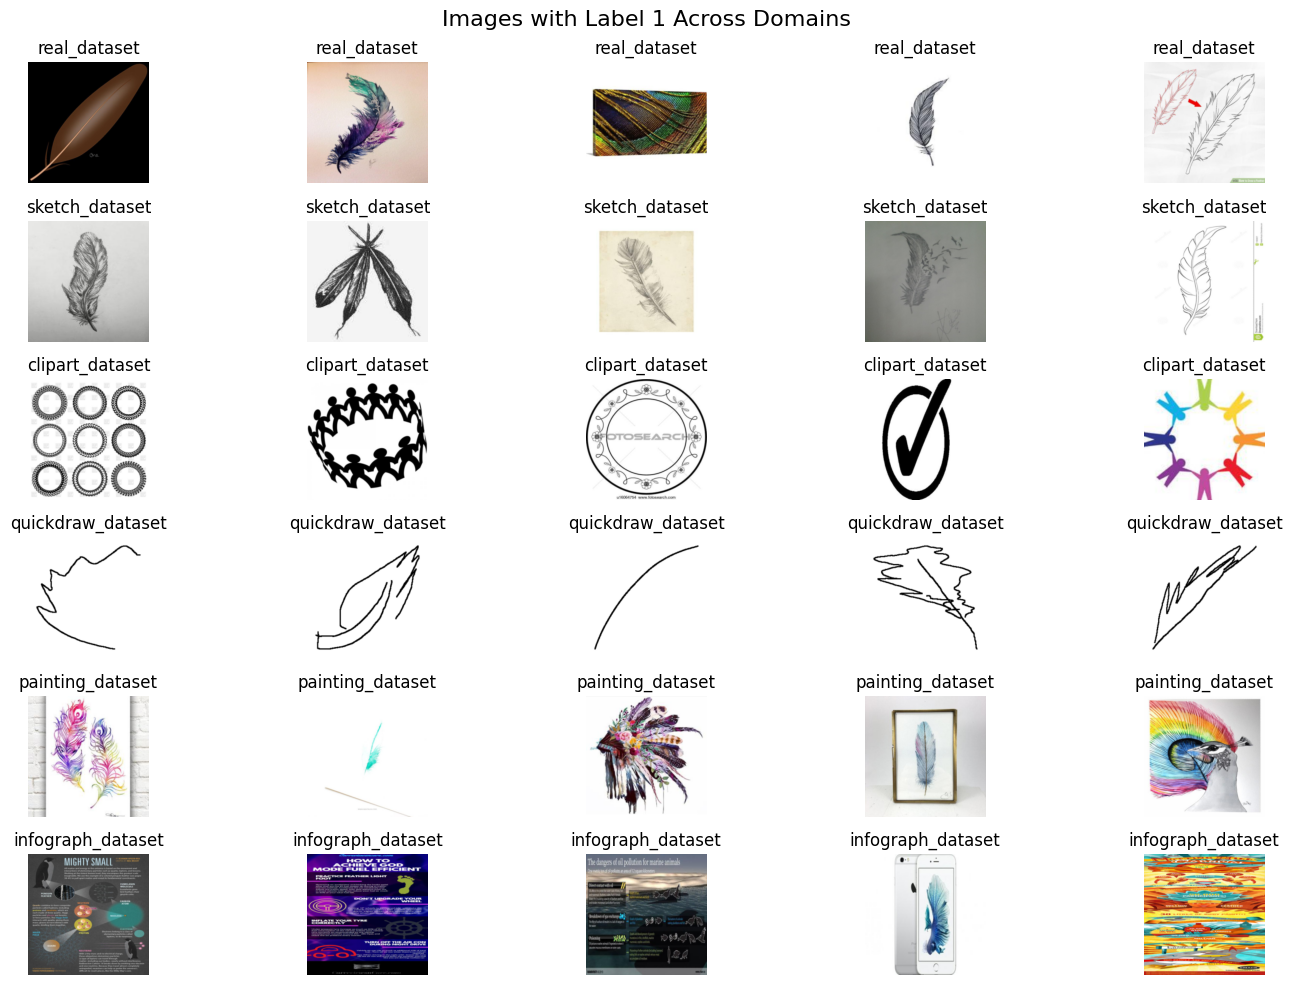

In [8]:
print("Visualizing Train Loader")
# Visualize the images from train loaders
visualize_same_label_across_domains(train_dataloaders, label_to_check=1, num_images_per_domain=5)

print("...")
print("...")
print("...")
print("Visualizing Test Loader")
# Visualize the images from test loaders
visualize_same_label_across_domains(test_dataloaders, label_to_check=1, num_images_per_domain=5)


In [9]:


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# **Data Preparation and Dataset Loading**

In [10]:
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Placeholder paths for datasets
dataset_paths = {
    'real': '/content/dataset/domain/Data/real',
    'sketch': '/content/dataset/domain/Data/sketch',
    'clipart': '/content/dataset/domain/Data/clipart',
    'quickdraw': '/content/dataset/domain/Data/quickdraw',
    'painting': '/content/dataset/domain/Data/painting',
    'infograph': '/content/dataset/domain/Data/infograph'
}

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def load_custom_dataset(dataset_path, transform=None, max_classes=10):
    images, labels = [], []
    class_to_label = {}
    current_label = 0

    for root, dirs, files in os.walk(dataset_path):
        if files:
            class_name = os.path.basename(root)
            if class_name not in class_to_label:
                if current_label >= max_classes:
                    continue
                class_to_label[class_name] = current_label
                current_label += 1

            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_path = os.path.join(root, file)
                    images.append(image_path)
                    labels.append(class_to_label[class_name])

    if not images:
        raise ValueError(f"No valid images found in dataset path: {dataset_path}")

    return CustomDataset(images, labels, transform)

# Create train and test loaders for each domain
batch_size = 32
train_ratio = 0.8
max_classes = 10
dataset_size=0.35

loaders = {}

for domain, path in dataset_paths.items():
    dataset = load_custom_dataset(path, transform=transform, max_classes=max_classes)

    # Split into train and test datasets
    used_dataset_size = int(len(dataset) * dataset_size)
    dataset = random_split(dataset, [used_dataset_size, len(dataset) - used_dataset_size])[0]

    train_size = int(len(dataset) * train_ratio)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Store loaders in dictionary
    loaders[domain] = {
        'train': train_loader,
        'test': test_loader
    }

    print(f"{domain} - Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}")

# Access train and test loaders for a specific domain
# Example: loaders['real']['train'], loaders['real']['test']




real - Train dataset size: 1184, Test dataset size: 296
sketch - Train dataset size: 769, Test dataset size: 193
clipart - Train dataset size: 675, Test dataset size: 169
quickdraw - Train dataset size: 1400, Test dataset size: 350
painting - Train dataset size: 996, Test dataset size: 250
infograph - Train dataset size: 882, Test dataset size: 221


# **Model Definition - SimpleCNN**

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# **Fed Avg**

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

# Local update function for a single client
def local_update(model, train_loader, epochs, learning_rate, device):
    """
    Perform local training on a single client's data.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the client's training data.
        epochs: Number of local training epochs.
        learning_rate: Learning rate for the optimizer.
        device: Device to train on ('cuda' or 'cpu').

    Returns:
        Trained model state dictionary.
    """
    model = deepcopy(model)  # Avoid altering the global model directly
    model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return model.state_dict()

# FedAvg function for aggregating local updates
def fedavg(global_model, client_states):
    """
    Perform Federated Averaging to aggregate client updates.

    Args:
        global_model: The global model.
        client_states: List of state dictionaries from local updates.

    Returns:
        Updated global model state dictionary.
    """
    global_state = global_model.state_dict()
    for key in global_state.keys():
        global_state[key] = torch.mean(
            torch.stack([client_state[key].float() for client_state in client_states]), dim=0
        )
    return global_state

# FedAvg training loop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to evaluate model accuracy on a test loader
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model's accuracy on the given test data.

    Args:
        model: PyTorch model to evaluate.
        test_loader: DataLoader for the test data.
        device: Device to evaluate on ('cuda' or 'cpu').

    Returns:
        Accuracy as a percentage.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return 100.0 * correct / total

# Updated FedAvg training function with accuracy tracking
def fedavg_training_with_tracking(global_model, loaders, rounds, local_epochs, learning_rate, device):
    """
    Perform Federated Averaging training with accuracy tracking.

    Args:
        global_model: The global model to train.
        loaders: Dictionary of train loaders for each domain.
        rounds: Number of communication rounds.
        local_epochs: Number of epochs for local training.
        learning_rate: Learning rate for local updates.
        device: Device to train on ('cuda' or 'cpu').

    Returns:
        Trained global model and accuracy history.
    """
    global_model.to(device)
    accuracy_history = {domain: [] for domain in loaders.keys()}

    for round_num in range(rounds):
        print(f"Round {round_num + 1}/{rounds}")

        # Evaluate on each domain's test set before the round
        for domain, loaders_dict in loaders.items():
            test_loader = loaders_dict['test']
            accuracy = evaluate_model(global_model, test_loader, device)
            accuracy_history[domain].append(accuracy)
            print(f"Domain: {domain}, Round: {round_num + 1}, Accuracy: {accuracy:.2f}%")

        client_states = []

        # Local training on each client's data
        for domain, loaders_dict in loaders.items():
            train_loader = loaders_dict['train']
            print(f"Training on client: {domain}")
            client_state = local_update(global_model, train_loader, local_epochs, learning_rate, device)
            client_states.append(client_state)

        # Aggregating updates using FedAvg
        global_model.load_state_dict(fedavg(global_model, client_states))

    return global_model, accuracy_history



# **Displaying Dataset & Class Accuracies**

In [13]:
def visualize_accuracy(accuracy_history, rounds):
    """
    Visualize the test accuracy for each domain across communication rounds.

    Args:
        accuracy_history: Dictionary with domain names as keys and lists of accuracies as values.
        rounds: Number of communication rounds.

    Returns:
        None. Displays the plot.
    """
    plt.figure(figsize=(10, 6))
    for domain, accuracies in accuracy_history.items():
        plt.plot(range(1, rounds + 1), accuracies, label=domain)

    plt.xlabel("Communication Rounds")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Federated Learning Test Accuracy per Domain")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


# **Plotting Overall Accuracy vs Communication Rounds**

Round 1/20
Domain: real, Round: 1, Accuracy: 8.45%
Domain: sketch, Round: 1, Accuracy: 5.70%
Domain: clipart, Round: 1, Accuracy: 6.51%
Domain: quickdraw, Round: 1, Accuracy: 6.29%
Domain: painting, Round: 1, Accuracy: 6.00%
Domain: infograph, Round: 1, Accuracy: 8.14%
Training on client: real
Training on client: sketch
Training on client: clipart
Training on client: quickdraw
Training on client: painting
Training on client: infograph
Round 2/20
Domain: real, Round: 2, Accuracy: 30.41%
Domain: sketch, Round: 2, Accuracy: 15.54%
Domain: clipart, Round: 2, Accuracy: 20.12%
Domain: quickdraw, Round: 2, Accuracy: 10.57%
Domain: painting, Round: 2, Accuracy: 18.00%
Domain: infograph, Round: 2, Accuracy: 15.84%
Training on client: real
Training on client: sketch
Training on client: clipart
Training on client: quickdraw
Training on client: painting
Training on client: infograph
Round 3/20
Domain: real, Round: 3, Accuracy: 37.16%
Domain: sketch, Round: 3, Accuracy: 14.51%
Domain: clipart, Roun

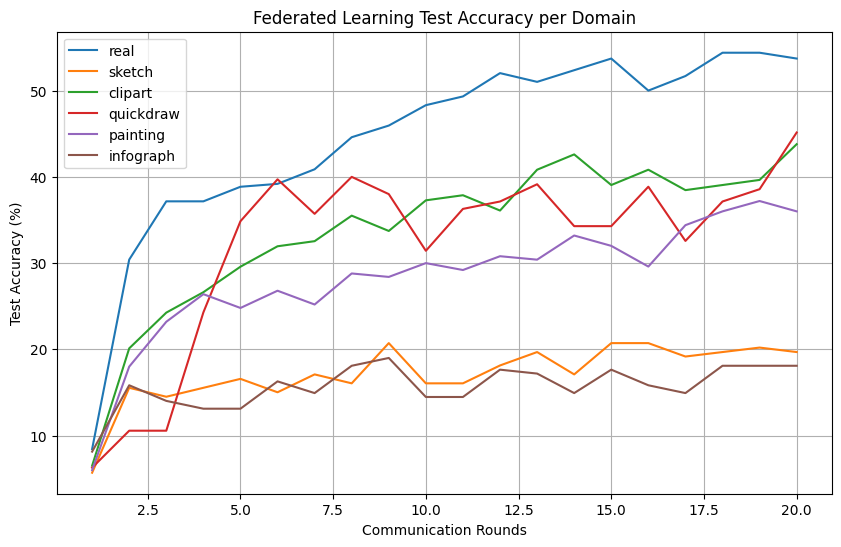

In [14]:
# Initialize the global model
global_model = SimpleCNN(num_classes=10)

# Define training parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rounds = 20
local_epochs = 10
learning_rate = 0.001

# Train using FedAvg with accuracy tracking
trained_model, accuracy_history = fedavg_training_with_tracking(
    global_model, loaders, rounds, local_epochs, learning_rate, device
)

# Visualize test accuracy
visualize_accuracy(accuracy_history, rounds)


In [15]:
import json

# Path to save the JSON file
output_file = "accuracy_history.json"

# Save the accuracy history to the file
with open(output_file, "w") as f:
    json.dump(accuracy_history, f, indent=4)

print(f"Accuracy history saved to {output_file}")

Accuracy history saved to accuracy_history.json


# **Class Accuracies vs Number Communication Rounds**